### Bloco 1: Importação de Bibliotecas e Configuração de Variáveis
Este bloco define as bibliotecas necessárias e todas as variáveis de configuração, como os caminhos dos arquivos, os códigos de alerta COBRADE e os identificadores dos sensores do CEMADEN.

In [1]:
# Bloco 1: Importação de Bibliotecas e Configuração de Variáveis

import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- VARIÁVEIS GLOBAIS DE CONFIGURAÇÃO ---
# Assuma que a pasta 'data/raw' está um nível acima do seu notebook (../data/raw)
PASTA_RAW = '../data/raw/' 

# Caminhos dos Arquivos de Eventos
# O nome do arquivo oficial foi padronizado no código anterior para ser mais robusto, mas você pode ajustar se necessário.
caminho_eventos_oficiais = os.path.join(PASTA_RAW, 'dados_tratados_enchente_francisco_morato - Dados agregados.csv')
caminho_eventos_nao_oficiais = os.path.join(PASTA_RAW, 'eventos_nao_oficiais.csv') 

# Códigos e Cidades para definir o Rótulo Y (Eventos)
codigos_alerta = ['12100 - Inundações', '12200 - Enxurradas', '12300 - Alagamentos', '13214 - Tempestade Local/Convectiva - Chuvas Intensas']
cidades_alerta = ['Francisco Morato', 'Caieiras', 'Cajamar', 'Campo Limpo Paulista', 'Franco da Rocha', 'Mairiporã', 'Jundiaí']

# Arquivos CEMADEN:
# Morato: 3516309
PADRAO_FM = 'PED_Cemaden_3516309*A.csv'
# Padrões dos vizinhos: Caieiras (3509007), Franco da Rocha (3516408), Jundiaí (3525904)
padroes_vizinhos = [
    'PED_Cemaden_3509007*A.csv', 
    'PED_Cemaden_3516408*A.csv', 
    'PED_Cemaden_3525904*A.csv'
]
# Padrão geral para varrer a pasta
PADRAO_TODOS_CEMADEN = 'PED_Cemaden_*.csv'

# Colunas e Códigos Padrão nos arquivos CEMADEN
COLUNA_DATA_REAL = 'datahora'
COLUNA_CHUVA_REAL = 'valor'
FORMATO_DATA_REAL = '%Y-%m-%d %H:%M:%S'
ID_SENSOR_PRECIPITACAO = 240 # Código CEMADEN para Precipitação em mm

## Bloco 2: Processamento dos Rótulos (Target Y)
Este bloco carrega e consolida as datas de eventos (enchentes, alagamentos, etc.) a partir dos arquivos oficiais e não oficiais para criar a lista mestra de datas de alerta (datas_alerta_mestra).

In [2]:
# Bloco 2: Processamento dos Rótulos (Target Y)

# --- A. Processar Dados Oficiais (S2ID) ---
try:
    df_oficial = pd.read_csv(caminho_eventos_oficiais)
    # Conversão de data do formato 'DD/MM/YYYY' para objeto date
    df_oficial['DATA_EVENTO'] = pd.to_datetime(df_oficial['Registro'], format='%d/%m/%Y', errors='coerce').dt.date
    # Filtra pelos códigos COBRADE de interesse
    df_oficial_filtrado = df_oficial[df_oficial['COBRADE'].isin(codigos_alerta)].dropna(subset=['DATA_EVENTO'])
    datas_oficiais = df_oficial_filtrado['DATA_EVENTO'].unique()
except Exception as e:
    print(f"ERRO ao carregar dados oficiais: {e}. Prosseguindo sem eles.")
    datas_oficiais = np.array([])


# --- B. Processar Dados Não Oficiais ---
try:
    df_nao_oficial = pd.read_csv(caminho_eventos_nao_oficiais, sep=',') 
    # Conversão de data do formato 'DD/MM/YYYY' para objeto date
    df_nao_oficial['DATA_EVENTO'] = pd.to_datetime(df_nao_oficial['Data do Evento'], format='%d/%m/%Y', errors='coerce').dt.date
    df_nao_oficial = df_nao_oficial.dropna(subset=['DATA_EVENTO'])
    # Filtra pelas cidades vizinhas e Francisco Morato
    df_nao_oficial_filtrado = df_nao_oficial[df_nao_oficial['Cidade/Município'].isin(cidades_alerta)]
    datas_nao_oficiais = df_nao_oficial_filtrado['DATA_EVENTO'].unique()
except Exception as e:
    print(f"ERRO ao carregar dados não oficiais: {e}. Prosseguindo sem eles.")
    datas_nao_oficiais = np.array([])
    
# --- C. Consolidação Final do Rótulo ---
# Une as datas e remove duplicatas
datas_alerta_mestra = np.unique(np.concatenate([datas_oficiais, datas_nao_oficiais]))
print(f"✅ Rótulo Mestre Y (TARGET_ENCHENTE) definido. Total de dias com evento: {len(datas_alerta_mestra)}")

✅ Rótulo Mestre Y (TARGET_ENCHENTE) definido. Total de dias com evento: 173


## Bloco 3: Função de Processamento de Chuva (CEMADEN)
Esta função é a inteligência por trás da agregação. Ela aceita uma lista de padrões de arquivos (por exemplo, todos os de Morato) e consolida a chuva máxima registrada a cada 10 minutos entre todos esses sensores.

In [3]:
# Bloco 3: Função de Processamento de Chuva (CEMADEN) - CORRIGIDO

def process_cemaden_files(file_patterns, output_col_name):
    """
    Carrega e consolida dados de precipitação de múltiplos arquivos CEMADEN,
    calculando a precipitação MÁXIMA entre os sensores a cada 10 minutos.
    
    CORREÇÃO: Incluído .dt.floor('10min') para garantir alinhamento do índice
    e evitar MemoryError em grandes datasets.
    """
    arquivos_cemaden = []
    # Busca os arquivos que correspondem aos padrões fornecidos
    for pattern in file_patterns:
        arquivos_cemaden.extend(glob.glob(os.path.join(PASTA_RAW, pattern)))
    
    arquivos_cemaden = list(set(arquivos_cemaden))
        
    df_chuva_consolidado = pd.DataFrame()
    print(f"\nIniciando consolidação de {len(arquivos_cemaden)} sensores para {output_col_name}...")

    for arquivo in arquivos_cemaden:
        try:
            sensor_id = os.path.basename(arquivo).split('_')[-1].replace('.csv', '')
            df_sensor = pd.read_csv(arquivo, sep=',') 
            df_sensor = df_sensor[df_sensor['id_sensor'] == ID_SENSOR_PRECIPITACAO].copy()
            
            df_sensor = df_sensor.rename(columns={
                COLUNA_DATA_REAL: 'DATA_HORA',  
                COLUNA_CHUVA_REAL: f'CHUVAMM_{sensor_id}'
            })
            df_sensor = df_sensor[['DATA_HORA', f'CHUVAMM_{sensor_id}']].copy()
            
            # --- FIX: GARANTINDO O ALINHAMENTO DO ÍNDICE ---
            df_sensor['DATA_HORA'] = pd.to_datetime(df_sensor['DATA_HORA'], format=FORMATO_DATA_REAL, errors='coerce')
            df_sensor = df_sensor.dropna(subset=['DATA_HORA'])
            # Arredonda o timestamp para baixo (floor) para o intervalo de 10 minutos.
            df_sensor['DATA_HORA'] = df_sensor['DATA_HORA'].dt.floor('10min') 
            df_sensor = df_sensor.set_index('DATA_HORA')
            # ------------------------------------------------
            
            df_sensor[f'CHUVAMM_{sensor_id}'] = pd.to_numeric(df_sensor[f'CHUVAMM_{sensor_id}'], errors='coerce')
            df_sensor = df_sensor[df_sensor[f'CHUVAMM_{sensor_id}'] >= 0]
            
            # Agrupa por índice para resolver o problema de múltiplas leituras no mesmo 'floor'
            df_sensor = df_sensor.groupby(df_sensor.index).max()

            if df_chuva_consolidado.empty:
                df_chuva_consolidado = df_sensor
            else:
                df_chuva_consolidado = df_chuva_consolidado.join(df_sensor, how='outer')

        except Exception as e:
            print(f"Erro ao processar o arquivo {arquivo}: {e}")

    # Calcula a precipitação MÁXIMA entre todos os sensores no DataFrame
    chuva_cols = [col for col in df_chuva_consolidado.columns if col.startswith('CHUVAMM_')]
    if not chuva_cols:
         print(f"🚨 ERRO: Nenhuma coluna de chuva encontrada para {output_col_name}.")
         return pd.DataFrame()
         
    df_result = pd.DataFrame(index=df_chuva_consolidado.index)
    df_result[output_col_name] = df_chuva_consolidado[chuva_cols].max(axis=1)
    
    print(f"✅ Consolidação de {output_col_name} concluída. Total de timestamps: {len(df_result)}")
    return df_result.dropna()

## Bloco 4: Criação das Features de Francisco Morato (X1)
Usa a função de consolidação para Francisco Morato (6 sensores) e calcula os acumulados de chuva (3h, 6h, 12h, 24h).

In [19]:
# Bloco 4: Criação das Features de Francisco Morato (X1)

# Bloco 4: Criação das Features de Francisco Morato (X1) - CORRIGIDO

# Assuma que 'process_cemaden_files' foi executada no Bloco 3
df_chuva_fm = process_cemaden_files([PADRAO_FM], 'PRECIPITACAO_MAX_FM')

df_final = df_chuva_fm.copy()

# --- 1. Features de Acumulado (FM) ---
janelas_fm = [3, 6, 12, 24] 
for janela in janelas_fm:
    roll_window = janela * 6 
    df_final[f'Chuva_FM_{janela}h'] = (
        df_final['PRECIPITACAO_MAX_FM']
        .rolling(window=roll_window, min_periods=roll_window)
        .sum()
    )

# --- 2. Feature de INTENSIDADE MÁXIMA (FM) ---
# Máxima precipitação em qualquer sensor de FM em uma janela de 1 hora (6 registros de 10 min)
roll_window_1h = 6 
df_final['Chuva_FM_Max_1h'] = (
    df_final['PRECIPITACAO_MAX_FM']
    .rolling(window=roll_window_1h, min_periods=roll_window_1h)
    .max()
)

print("✅ Features de Acumulado e Intensidade Máxima de Francisco Morato (X1) prontas.")
print(df_final.head())


Iniciando consolidação de 6 sensores para PRECIPITACAO_MAX_FM...
✅ Consolidação de PRECIPITACAO_MAX_FM concluída. Total de timestamps: 241259
✅ Features de Acumulado e Intensidade Máxima de Francisco Morato (X1) prontas.
                     PRECIPITACAO_MAX_FM  Chuva_FM_3h  Chuva_FM_6h  \
DATA_HORA                                                            
2020-01-01 00:00:00                  0.0          NaN          NaN   
2020-01-01 00:10:00                  0.0          NaN          NaN   
2020-01-01 00:20:00                  0.0          NaN          NaN   
2020-01-01 00:30:00                  0.0          NaN          NaN   
2020-01-01 00:40:00                  0.0          NaN          NaN   

                     Chuva_FM_12h  Chuva_FM_24h  Chuva_FM_Max_1h  
DATA_HORA                                                         
2020-01-01 00:00:00           NaN           NaN              NaN  
2020-01-01 00:10:00           NaN           NaN              NaN  
2020-01-01 00:20:00

## Bloco 5: Criação das Features de Cidades Vizinhas (X2) e União dos Dados
Usa a função de consolidação para os sensores vizinhos (Caieiras, Franco da Rocha e Jundiaí) e cria o acumulado de 6 horas para essas cidades. Depois, junta tudo em df_final.

In [20]:
# Bloco 5: Criação das Features de Cidades Vizinhas (X2) e União dos Dados (ATUALIZADO)

# Bloco 5: Criação das Features de Cidades Vizinhas (X2) e União dos Dados - CORRIGIDO

df_chuva_vz = process_cemaden_files(padroes_vizinhos, 'PRECIPITACAO_MAX_VZ')

# Garante que 'df_final' de FM já foi criado no Bloco 4 antes de fazer o join
df_final = df_final.join(df_chuva_vz, how='inner')

# --- 1. Features de Acumulado (Vizinhos) ---
janelas_vizinhas = [6, 24]
for janela in janelas_vizinhas:
    roll_window_vz = janela * 6
    df_final[f'Chuva_Vizinha_{janela}h'] = (
        df_final['PRECIPITACAO_MAX_VZ']
        .rolling(window=roll_window_vz, min_periods=roll_window_vz)
        .sum()
    )

# --- 2. Feature de INTENSIDADE MÁXIMA (Vizinhos) ---
# Máxima precipitação em qualquer sensor vizinho em uma janela de 1 hora (6 registros de 10 min)
roll_window_1h = 6 
df_final['Chuva_Vizinha_Max_1h'] = (
    df_final['PRECIPITACAO_MAX_VZ']
    .rolling(window=roll_window_1h, min_periods=roll_window_1h)
    .max()
)

print("✅ Features de Cidades Vizinhas (Acumulado e Intensidade Máxima) prontas e unidas.")
print(df_final.head())


Iniciando consolidação de 13 sensores para PRECIPITACAO_MAX_VZ...
✅ Consolidação de PRECIPITACAO_MAX_VZ concluída. Total de timestamps: 247539
✅ Features de Cidades Vizinhas (Acumulado e Intensidade Máxima) prontas e unidas.
                     PRECIPITACAO_MAX_FM  Chuva_FM_3h  Chuva_FM_6h  \
DATA_HORA                                                            
2020-01-01 00:00:00                  0.0          NaN          NaN   
2020-01-01 00:10:00                  0.0          NaN          NaN   
2020-01-01 00:20:00                  0.0          NaN          NaN   
2020-01-01 00:30:00                  0.0          NaN          NaN   
2020-01-01 00:50:00                  0.0          NaN          NaN   

                     Chuva_FM_12h  Chuva_FM_24h  Chuva_FM_Max_1h  \
DATA_HORA                                                          
2020-01-01 00:00:00           NaN           NaN              NaN   
2020-01-01 00:10:00           NaN           NaN              NaN   
2020-01-01 

## Bloco 6: Criação Final do Target (Y) e Limpeza
Este bloco é o mais importante para o problema de previsão. Ele usa as datas de evento (Y) e desloca o valor no tempo para trás, transformando o problema em: "Com base na chuva AGORA (X), teremos um evento nas próximas 48 horas (Y)?".

In [21]:
# Bloco 6: Criação Final do Target (Y) e Limpeza (CORRIGIDO com Taxa de Aumento)

# --- 1. FEATURE AVANÇADA: TAXA DE AUMENTO DE CHUVA (FM) ---
# (Chuva nas últimas 6h) / (Chuva nas últimas 24h - 6h)
# Isso mede a intensidade do pico recente em relação à saturação anterior
df_final['Chuva_FM_Taxa_Aumento'] = (
    df_final['Chuva_FM_6h'] / (df_final['Chuva_FM_24h'] - df_final['Chuva_FM_6h'])
)
# Tratar divisões por zero ou valores muito pequenos (chuva acumulada = 0 ou ~0)
df_final['Chuva_FM_Taxa_Aumento'] = df_final['Chuva_FM_Taxa_Aumento'].replace([np.inf, -np.inf], 0).fillna(0)


# --- 2. CRIAÇÃO FINAL DO TARGET (Y) E LIMPEZA (Demais passos sem alteração) ---
janela_alerta = 48 * 6 

df_final['Houve_Enchente_No_Dia'] = np.isin(
    df_final.index.date, 
    datas_alerta_mestra 
).astype(int)

df_final['TARGET_ENCHENTE'] = df_final['Houve_Enchente_No_Dia'].shift(-janela_alerta)

# Remove NaNs gerados pelo rolling() e pelo shift()
df_final = df_final.dropna()
df_final['TARGET_ENCHENTE'] = df_final['TARGET_ENCHENTE'].astype(int)

# 3. Define as features X (todas que começam com 'Chuva_')
features_cols = [
    col for col in df_final.columns 
    if col.startswith('Chuva_')
]

# Remove colunas auxiliares
df_final = df_final.drop(columns=[
    'Houve_Enchente_No_Dia', 
    'PRECIPITACAO_MAX_FM', 
    'PRECIPITACAO_MAX_VZ'
]) 


print("\n===================================================================")
print("✅ Base de dados final pronta com Novas Features (Intensidade e Taxa de Aumento).")
print(f"Total de Features X utilizadas: {len(features_cols)}")
print(f"Exemplo de Features X: {features_cols[:3]}...")
print("Total de amostras na base de dados:", len(df_final))
print("===================================================================")


✅ Base de dados final pronta com Novas Features (Intensidade e Taxa de Aumento).
Total de Features X utilizadas: 9
Exemplo de Features X: ['Chuva_FM_3h', 'Chuva_FM_6h', 'Chuva_FM_12h']...
Total de amostras na base de dados: 214169


## Bloco 7: Treinamento e Avaliação do Modelo
Este bloco final divide os dados em treino e teste e treina um modelo Random Forest, avaliando-o com a matriz de confusão e o relatório de classificação.

Amostras de Treino: 203460
Amostras de Teste: 10709
Eventos (Y=1) no Teste: 902

Iniciando o treinamento do Random Forest apenas com Precipitação...
✅ Treinamento concluído!

--- MATRIZ DE CONFUSÃO (Apenas Chuva) ---
[[Verdadeiro Negativo (0) | Falso Positivo (Alarme Falso)]
 [Falso Negativo (Falha de Alerta) | Verdadeiro Positivo (Alerta Correto)]]
[[7661 2146]
 [ 151  751]]

--- RELATÓRIO DE CLASSIFICAÇÃO ---
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      9807
           1       0.26      0.83      0.40       902

    accuracy                           0.79     10709
   macro avg       0.62      0.81      0.63     10709
weighted avg       0.92      0.79      0.83     10709



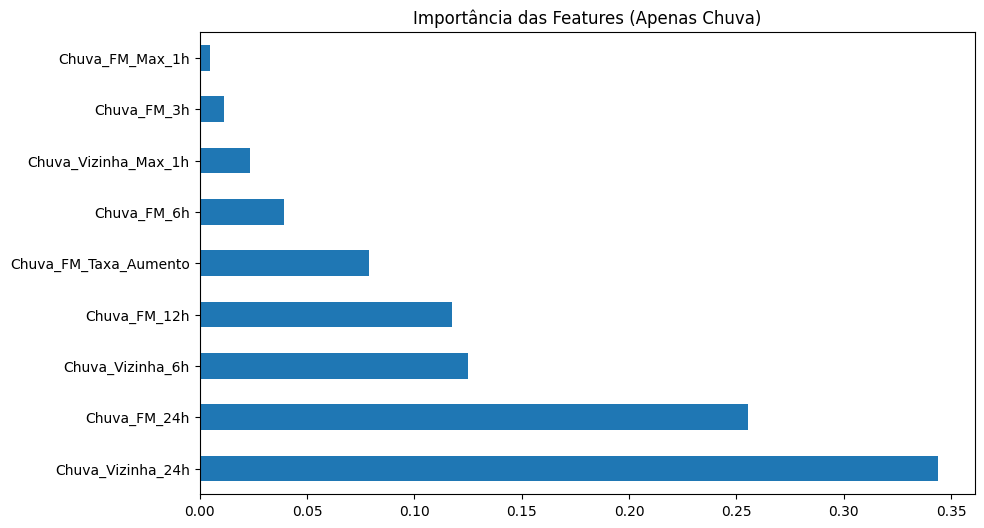

In [22]:
# Bloco 7: Treinamento e Avaliação do Modelo

# 1. SEPARAÇÃO X e Y (Features e Target)
X = df_final[features_cols].values 
y = df_final['TARGET_ENCHENTE'].values 

# Divisão Treino/Teste. Usamos 'stratify=y' para garantir que os poucos eventos Y=1
# sejam distribuídos de forma proporcional entre treino e teste.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.05, # Apenas 5% para teste, mas o suficiente
    random_state=42, 
    stratify=y
)

print(f"Amostras de Treino: {len(X_train)}")
print(f"Amostras de Teste: {len(X_test)}")
print(f"Eventos (Y=1) no Teste: {y_test.sum()}")

# 2. TREINAMENTO DO MODELO
modelo = RandomForestClassifier(
    n_estimators=200, 
    random_state=42, 
    class_weight='balanced', # Crucial para lidar com o desbalanceamento (muito mais Y=0 que Y=1)
    max_depth=10, 
    n_jobs=-1 # Usa todos os cores da CPU
)

print("\nIniciando o treinamento do Random Forest apenas com Precipitação...")
modelo.fit(X_train, y_train)
print("✅ Treinamento concluído!")

# 3. AVALIAÇÃO E ANÁLISE DE RESULTADOS
y_pred = modelo.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\n--- MATRIZ DE CONFUSÃO (Apenas Chuva) ---")
print("[[Verdadeiro Negativo (0) | Falso Positivo (Alarme Falso)]")
print(" [Falso Negativo (Falha de Alerta) | Verdadeiro Positivo (Alerta Correto)]]")
print(conf_matrix)

print("\n--- RELATÓRIO DE CLASSIFICAÇÃO ---")
print(classification_report(y_test, y_pred))

# 4. Análise da Importância das Features
plt.figure(figsize=(10, 6))
feature_importances = pd.Series(modelo.feature_importances_, index=features_cols)
feature_importances.sort_values(ascending=False).plot(kind='barh', title='Importância das Features (Apenas Chuva)')
plt.show()


Iniciando o treinamento do Random Forest (Class_Weight=Balanced)...
✅ Treinamento concluído!

--- MATRIZ DE CONFUSÃO (Threshold = 0.6) ---
[[8312 1495]
 [ 208  694]]

--- RELATÓRIO DE CLASSIFICAÇÃO (Threshold = 0.6) ---
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      9807
           1       0.32      0.77      0.45       902

    accuracy                           0.84     10709
   macro avg       0.65      0.81      0.68     10709
weighted avg       0.92      0.84      0.87     10709


**Métricas Chave (Target=1):**
Precision (Confiabilidade): 0.32
Recall (Segurança - Falso Negativo): 0.77


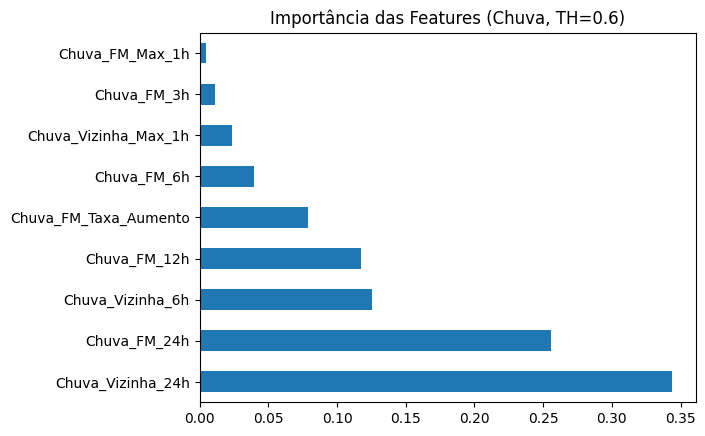

In [23]:
# Bloco 7: TREINAMENTO E AVALIAÇÃO COM PROBABILIDADES

from sklearn.metrics import precision_recall_curve, auc

# 1. SEPARAÇÃO X e Y (Features e Target) - Sem mudança
X = df_final[features_cols].values 
y = df_final['TARGET_ENCHENTE'].values 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.05, 
    random_state=42, 
    stratify=y
)

# 2. TREINAMENTO DO MODELO (Mantendo 'balanced' para máxima captura)
modelo = RandomForestClassifier(
    n_estimators=200, 
    random_state=42, 
    class_weight='balanced', # Mantém o peso alto para a classe 1 (máximo Recall)
    max_depth=10, 
    n_jobs=-1
)
print("\nIniciando o treinamento do Random Forest (Class_Weight=Balanced)...")
modelo.fit(X_train, y_train)
print("✅ Treinamento concluído!")

# 3. PREVISÃO DE PROBABILIDADES
# Em vez de prever 0 ou 1 diretamente (.predict), prevemos as probabilidades (.predict_proba)
# A segunda coluna [:, 1] é a probabilidade de ser Target=1
y_proba = modelo.predict_proba(X_test)[:, 1]

# 4. AVALIAÇÃO COM THRESHOLD AJUSTADO
# Testaremos um novo threshold (ex: 0.5, 0.6, 0.7...)
# O threshold padrão é 0.5, mas vamos aumentar para 0.7 para forçar mais certeza!
novo_threshold = 0.6 

y_pred_ajustado = (y_proba >= novo_threshold).astype(int)

# 5. RESULTADOS
conf_matrix_ajustada = confusion_matrix(y_test, y_pred_ajustado)

print(f"\n--- MATRIZ DE CONFUSÃO (Threshold = {novo_threshold}) ---")
print(conf_matrix_ajustada)

print(f"\n--- RELATÓRIO DE CLASSIFICAÇÃO (Threshold = {novo_threshold}) ---")
report = classification_report(y_test, y_pred_ajustado, output_dict=True)
print(classification_report(y_test, y_pred_ajustado))

# Extração de Métricas Chave
precision_1 = report['1']['precision']
recall_1 = report['1']['recall']

print(f"\n**Métricas Chave (Target=1):**")
print(f"Precision (Confiabilidade): {precision_1:.2f}")
print(f"Recall (Segurança - Falso Negativo): {recall_1:.2f}")

# 6. Análise de Importância das Features (Sem alteração)
# ... (Código do gráfico de importância, que pode ser mantido)
feature_importances = pd.Series(modelo.feature_importances_, index=features_cols)
feature_importances.sort_values(ascending=False).plot(kind='barh', title=f'Importância das Features (Chuva, TH={novo_threshold})')
plt.show()


Iniciando o treinamento final do Random Forest (Class_Weight=Balanced)...
✅ Treinamento concluído!

RESULTADOS FINAIS - MODELO APENAS CHUVA (THRESHOLD = 0.6)

--- MATRIZ DE CONFUSÃO ---
[[Verdadeiro Negativo | Falso Positivo (Alarme Falso)]
 [Falso Negativo (Falha de Alerta) | Verdadeiro Positivo (Alerta Correto)]]
[[8312 1495]
 [ 208  694]]

--- RELATÓRIO DE CLASSIFICAÇÃO ---
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      9807
           1       0.32      0.77      0.45       902

    accuracy                           0.84     10709
   macro avg       0.65      0.81      0.68     10709
weighted avg       0.92      0.84      0.87     10709



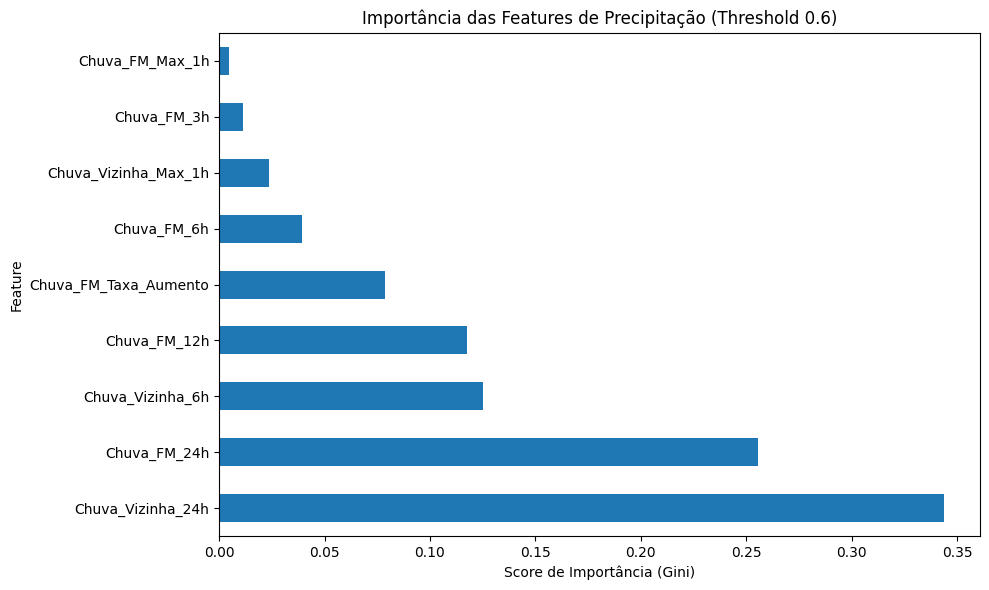


✅ O modelo de previsão com pluviômetros está finalizado.
Use o Threshold 0.6 para a análise final e a importância das features para discussão.


In [24]:
# Bloco 7: TREINAMENTO E ANÁLISE FINAL DO MODELO APENAS COM CHUVA (Threshold 0.6)

# --- 1. SEPARAÇÃO X e Y (Features e Target) ---
# A lista de features foi definida no Bloco 6 e inclui os acumulados de FM (3h, 6h, 12h, 24h)
# e os acumulados dos Vizinhos (6h, 24h).
X = df_final[features_cols].values 
y = df_final['TARGET_ENCHENTE'].values 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.05, 
    random_state=42, 
    stratify=y
)

# --- 2. TREINAMENTO DO MODELO ---
# Usamos 'class_weight=balanced' para garantir que o modelo priorize a captura da classe 1.
modelo = RandomForestClassifier(
    n_estimators=200, 
    random_state=42, 
    class_weight='balanced', 
    max_depth=10, 
    n_jobs=-1 
)

print("\nIniciando o treinamento final do Random Forest (Class_Weight=Balanced)...")
modelo.fit(X_train, y_train)
print("✅ Treinamento concluído!")

# --- 3. PREVISÃO DE PROBABILIDADES ---
y_proba = modelo.predict_proba(X_test)[:, 1]

# --- 4. AVALIAÇÃO COM THRESHOLD FINAL (0.6) ---
# O threshold 0.6 foi escolhido como o melhor compromisso entre Recall (segurança) e Precision.
novo_threshold = 0.6 

y_pred_ajustado = (y_proba >= novo_threshold).astype(int)

# --- 5. RESULTADOS FINAIS ---
conf_matrix_ajustada = confusion_matrix(y_test, y_pred_ajustado)

print(f"\n===================================================================")
print(f"RESULTADOS FINAIS - MODELO APENAS CHUVA (THRESHOLD = {novo_threshold})")
print(f"===================================================================")

print(f"\n--- MATRIZ DE CONFUSÃO ---")
print("[[Verdadeiro Negativo | Falso Positivo (Alarme Falso)]")
print(" [Falso Negativo (Falha de Alerta) | Verdadeiro Positivo (Alerta Correto)]]")
print(conf_matrix_ajustada)

print(f"\n--- RELATÓRIO DE CLASSIFICAÇÃO ---")
print(classification_report(y_test, y_pred_ajustado))

# --- 6. ANÁLISE DE IMPORTÂNCIA DAS FEATURES ---
plt.figure(figsize=(10, 6))
feature_importances = pd.Series(modelo.feature_importances_, index=features_cols)
feature_importances.sort_values(ascending=False).plot(kind='barh', title='Importância das Features (Modelo Final)')
plt.title(f'Importância das Features de Precipitação (Threshold {novo_threshold})')
plt.xlabel('Score de Importância (Gini)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\n✅ O modelo de previsão com pluviômetros está finalizado.")
print(f"Use o Threshold {novo_threshold} para a análise final e a importância das features para discussão.")


Iniciando o treinamento do XGBoost...


c:\Users\JoaoH\OneDrive\Documentos\Apps\analise_climatica\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:28:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Treinamento concluído!

RESULTADOS FINAIS - MODELO XGBOOST (THRESHOLD = 0.55)

--- MATRIZ DE CONFUSÃO ---
[[Verdadeiro Negativo | Falso Positivo (Alarme Falso)]
 [Falso Negativo (Falha de Alerta) | Verdadeiro Positivo (Alerta Correto)]]
[[8681 1126]
 [ 179  723]]

--- RELATÓRIO DE CLASSIFICAÇÃO ---
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      9807
           1       0.39      0.80      0.53       902

    accuracy                           0.88     10709
   macro avg       0.69      0.84      0.73     10709
weighted avg       0.93      0.88      0.90     10709



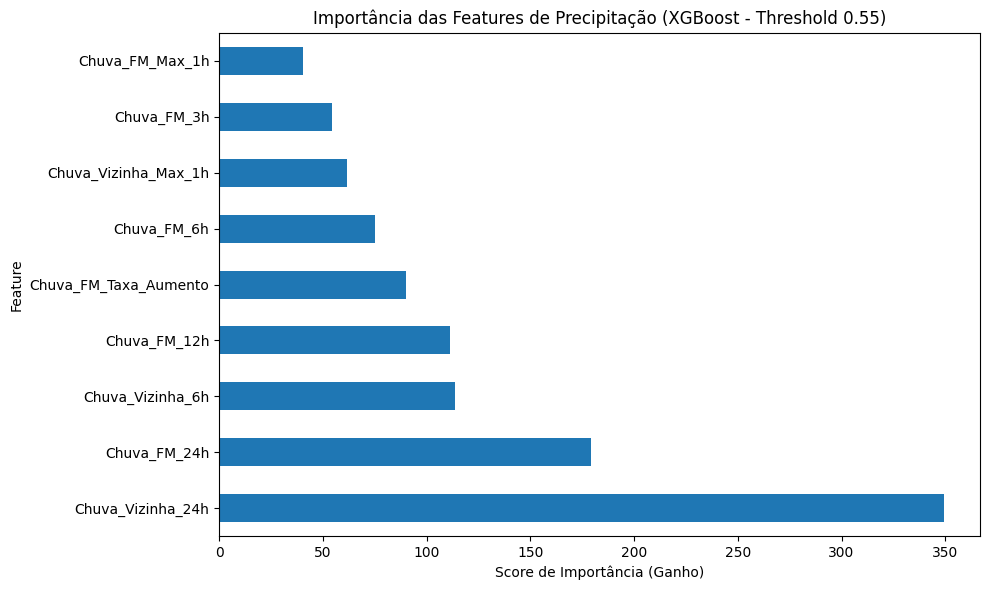

In [26]:
# Bloco 7: TREINAMENTO E ANÁLISE FINAL COM XGBOOST (Threshold 0.6)

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. SEPARAÇÃO X e Y (Features e Target)
X = df_final[features_cols].values 
y = df_final['TARGET_ENCHENTE'].values 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.05, 
    random_state=42, 
    stratify=y
)

# 2. TREINAMENTO DO MODELO (XGBoost)
# Calculando o peso para desbalanceamento: (Total de 0s) / (Total de 1s)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

modelo = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=300,
    max_depth=6, # Profundidade um pouco menor que o RF para evitar overfitting
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight, # Trata o desbalanceamento
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)

print("\nIniciando o treinamento do XGBoost...")
modelo.fit(X_train, y_train)
print("✅ Treinamento concluído!")

# 3. PREVISÃO DE PROBABILIDADES
y_proba = modelo.predict_proba(X_test)[:, 1]

# 4. AVALIAÇÃO COM THRESHOLD FINAL (0.6)
novo_threshold = 0.55 
y_pred_ajustado = (y_proba >= novo_threshold).astype(int)

# 5. RESULTADOS FINAIS
conf_matrix_ajustada = confusion_matrix(y_test, y_pred_ajustado)

print(f"\n===================================================================")
print(f"RESULTADOS FINAIS - MODELO XGBOOST (THRESHOLD = {novo_threshold})")
print(f"===================================================================")

print(f"\n--- MATRIZ DE CONFUSÃO ---")
print("[[Verdadeiro Negativo | Falso Positivo (Alarme Falso)]")
print(" [Falso Negativo (Falha de Alerta) | Verdadeiro Positivo (Alerta Correto)]]")
print(conf_matrix_ajustada)

print(f"\n--- RELATÓRIO DE CLASSIFICAÇÃO ---")
print(classification_report(y_test, y_pred_ajustado))

# 6. ANÁLISE DE IMPORTÂNCIA DAS FEATURES (XGBoost)
plt.figure(figsize=(10, 6))
# O XGBoost usa get_booster().get_score(importance_type='gain') para a melhor importância
feature_importances = pd.Series(modelo.get_booster().get_score(importance_type='gain'))
feature_importances.index = [features_cols[int(i[1:])] for i in feature_importances.index] # Mapeia f0, f1... para nomes
feature_importances.sort_values(ascending=False).plot(kind='barh', title='Importância das Features (XGBoost)')
plt.title(f'Importância das Features de Precipitação (XGBoost - Threshold {novo_threshold})')
plt.xlabel('Score de Importância (Ganho)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [29]:
import joblib
import os

# 1. Salvar o modelo (modelo é a variável do seu XGBoost)
NOME_DO_MODELO = 'modelo_enchente_final_xgb.joblib'
joblib.dump(modelo, NOME_DO_MODELO)
print(f"\n✅ Modelo XGBoost salvo como: {NOME_DO_MODELO}")

# 2. Salvar a lista de features (CRUCIAL para a ordem correta na inferência!)
NOME_FEATURES = 'features_cols.joblib'
joblib.dump(features_cols, NOME_FEATURES)
print(f"✅ Lista de features salvas como: {NOME_FEATURES}")




✅ Modelo XGBoost salvo como: modelo_enchente_final_xgb.joblib
✅ Lista de features salvas como: features_cols.joblib
